> # Cliff Walking - ML Final Project

პროექტის ლინკი - https://www.gymlibrary.dev/environments/toy_text/cliff_walking/

# მოკლე აღწერა

მოცემულ ნამუშევარში CliffWalking დავალების დასწავლის კოდია მოცემული. პროცესის მიზანია აგენტის იმ დონემდე დასწავლა, რომ მანდ მინიმალური რაოდენობის ნაბიჯების გამოყენებით შეძლოს მიზნის მიღწევა.
რადგან ამ შემთხვევაში observation და action სფეისები, Q-Learning ალგორითმი საკმარისი იქნება, რათა სწრაფად და ეფექტურად მოვახდინოთ აგენტის დასწავლა. კოდის პირველ ნაწილში აღწერილია ცვლადები, რომლებიც გამოიყენება დასწავლის პროცესში. n_states და n_actions არის სფეისების ზომები, რომლებიც გამოიყენება Q Table ს ზუსტი ზომის შექმნისთვის და მისი დეფოლტად 0 ების შევსებისთვის. learning_rate სწავლის სიჩქარე, რომელიც აკონტროლებს რამდენად განახლდება Q მნიშვნელობა ყოველ საფეხურზე. gamma არის discount ფაქტორი, რომელიც განსაზღვრავს მომავალი ჯილდოების მნიშვნელობას მიმდინარე ჯილდოებთან შედარებით. მოცემულ დავალებაში ვიცით რა მინიმალური ნაბიჯებია საჭირო მიზნის მისაღწევად და ამ რაოდენობას goal_steps ცვლადში ვინახავ. epsilon, min_epsilon, decay_rate: პარამეტრები ε-ხარბი სტრატეგიისთვის გამოიყენება, რომლებიც აკონტროლებენ მოქმედების შემთხვევით არჩევის ალბათობას. Q_table_final ში ჩაიწერება ის Q-Table რომელიც მიიღება დასწავლის ალგორითმის წარმატებით დასრულების შემდეგ.

# ბიბლიოთეკების დაიმპორტება

In [ ]:
import gymnasium
import numpy as np

# გარემოს შექმნა

ვქმნით `CliffWalking-v0` გარემოს `gymnasium` ბიბლიოთეკის საშუალებით (რომელიც უკვე დაიმპორტებული გვაქვს), ამისთვის კი ვიყენებთ მის `.make()` მეთოდს.


In [ ]:
env = gymnasium.make("CliffWalking-v0")

ცვლადების აღწერა:

In [85]:
n_states = env.observation_space.n
n_actions = env.action_space.n
default_learning_rate = 0.7
Q_table_final = np.zeros((n_states, n_actions))
default_gamma = 0.9
goal_steps = 13
default_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.995
final_reward_per_episode = []
episodes_needed = 0


# მეთოდები

**test_model მეთოდი**

გამოიყენება მოდელის შესამოწმებლად, დასწავლოს შემდეგ გვაქვს გამზადებული Q Table. ეს მეთოდი აკეთებს  სიმულაციას, სადაც მოქმედებას ირჩევს მხოლოდ და მხოლოდ Q Table ზე დაყრდნობით, რაც გვაძლევს საშუალებას გავიგოთ, მოხერხდა თუ არა აგენტის დასწავლა და სასურველი მიზნის მიღწევა. თუ ყველა ეპიზოდში აგენტმა სწორი, ანუ უმოკლესი 13 სთეფიანი, გზა აირჩია, ესეიგი აგენტის დასწავლა წარმატებით მოხდა და ვაბრუნებთ True, ხოლო თუ მას 13 ზე მეტი ბიჯის გადადგმა მოუწია ვაბრუნებთ False. რადგან დასაწყისში, როდესაც ცოტა ეპიზოდზე დასწავლისას ვუშვებ ამ მეთოდს, Q-Table არაა მთლიანად შევსებული და ბიჯების რაოდენობა შეიძლება ძალიან დიდი იყოს, ამითომ 2000 ლიმიტი დავუდე.

In [86]:

def test_model(Q_table) -> [bool, int]:
    state = env.reset()[0]
    terminated = False
    step = 0
    total_reward = 0
    while not terminated:
        action = np.argmax(Q_table[state])
        new_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        step += 1
        if step > 2000:
            break
        state = new_state
    if step > goal_steps:
        return False, total_reward, step
    return True, total_reward, step

**learning მეთოდი**

ქვემოთ მოცემული კოდი უკვე არის Q-Learning ალგორითმის რეალიზაცია. პირველი ციკლი არის ეპიზოდების სხვადასხვა რაოდენობის მოსინჯვა დასწავლისთვის. ჩვენი მიზანია არამარტო დავასწავლოთ აგენტი იმისთვის, რომ იპოვოს ყველაზე ოპტიმალური გზა, არამედ იპოვოს ეს ოპტიმალური გზა ყველაზე სწრაფად, ანუ რაც შეიძლება ნაკლები ეპიზოდის გამოყენებით. ამისთვის მაქვს გარეთა ციკლი, რომელიც 1 1000 მდე იტერირდება და თითოეულ რაოდენობა ეპიზოდებზე უშვებს დასწავლას, ყოველი დასწავლის დასაწყისში Q-Table და ეპსილონის მნიშნელობა ახლიდან ინიციალიზირდება დეფოლტებად, ხოლო დასწავლის ბოლოს ეშვება test_model მეთოდი, რომელიც მხოლოდ შევსებული Q-Table ზე დაყრდნობით გვეუბნება იპოვა თუ არა უმოკლესი გზა აგენტმა. პირველივე პოვნაზე ვაჩერებ ციკლს და ვიგებთ ეპიზოდების მინიმალურ რაოდენობას, რომელის საჭიროა ამ ალოგორითმით/სტრატეგიით დასასწავლად. დასწავლის შიდა ფორ ციკლი უკვე თითოეული ეპიზოდის სიმულაციას აღწერს, შიდა ვაილ ციკლი კი იქამდე იტერირდება სანამ არ დასრულდება ეპიზოდი. ყოველ ციკლზე ხდება 1 სთეფი, დასაწყისში კი ირჩევა ექშენი, რომელსაც აგენტი გააკეთებს. სწორედ აქ ვიყენებთ ეპსილონ-ხარბ სტრატეგიას, რომელიც მდგომარეობს იმაში, რომ როდესაც სულ თავიდან აგენტი იწყებს სწავლას, მისთვის გარემო აბსოლუტურად უცნობია, Q ველიუები 0 ებია, და მასზე დაყრდნობით ექშენის არჩევა გაჭირდება, სწორედ ამისთვის, ყოველ სთეფამდე რანდომული რიცხვი ირჩევა 0 დან 1 მდე და შემდეგ ეს რიცხვი დარდება ეფსილონს, თუ ის ნაკლების ეპსილონზე, ესეიგი აგენტი ირჩევს შემდეგ ექშენს რანდომულად, რაც ეხმარება მას გარემოს სწრაფად და ეფექტურად შესწავლისთვის, ხოლო თუ რანდომი მეტია ეპსილონზე, მაშინ უკვე Q-Table ის მეშვეობით იღებს იმ ექშენს, რომლის Q ველიო კონკრეტულ სთეითში ყველაზე მეტია. თითოეული ეპიზოდის დასრულებისას ეპსილონი მცირდება 0.5% ით.
ტრენინგის პროცესში Q-მნიშვნელობები აფდეითდება ბელმანის ფორმულის გამოყენებით:
𝑄(𝑠,𝑎)=𝑄(𝑠,𝑎)+learning_rate⋅(𝑟+𝛾⋅max(𝑄(𝑠',𝑎'))−𝑄(𝑠,𝑎))
Q(s,a) — Q-ფუნქციის მიმდინარე მნიშვნელობა კონკრეტული სთეითისთვის და ექშენისთვის
r - არის მოქმედების შესრულებისთვის მიღებული ჯილდო
𝛾 - არის discount ფაქტორი, რომელიც ითვალისწინებს მომავალ ჯილდოებს.
learning_rate - დასწავლის სისწრაფე
რადგან 𝑟 თითოეულ ბიჯზე არის უარყოფითი, შედეგად Q-მნიშვნელობა Q(s,a) შემცირდება, რაც მიუთითებს იმაზე, რომ ეს მოქმედება არ არის ოპტიმალური ამ მდგომარეობაში. აგენტი დაარეგულირებს თავის მოქმედებებს,ის მიზნად ისახავს მდგომარეობებს ნაკლებად უარყოფითი ჯილდოთი.მოცემულ დავალებაში აგენტი ცდილობს მაქსიმალურად გაზარდოს მისი ჯამური ჯილდო. რადგან ყოველი ნაბიჯი იწვევს უარყოფით ჯილდოს (-1 ყოველ ნაბიჯზე), აგენტი იქნება მოტივირებული, მოიძიოს გზები, რომლებიც საჭიროებენ უმცირეს ნაბიჯებს მიზნის მისაღწევად, რათა შემცირდეს დაგროვილი დანაკარგები.სხვა სიტყვებით რომ ვთქვათ, რაც უფრო მეტ ნაბიჯს დგამს აგენტი, მით მეტ უარყოფით ჯილდოს აგროვებს იგი. ამიტომ, აგენტი ცდილობს დაასრულოს დავალება რაც შეიძლება სწრაფად. ამ დავალებაში დასწავლა საკმაოდ სწრაფად ხდება, სჭირდება 3-6 ეპიზოდი, ეს რიცხვი განსხვავდება, რადგან როგორც აღვნიშნე, დასაწყისში რანდომულად ვირჩევთ ექშენებს და ისე ვასწავლით, ამიტომ ამ რანდომზეა დამოკიდებული თავიდან რამდენად სწრაფად დაასწავლის.

In [87]:
def learning(learning_rate=default_learning_rate, gamma=default_gamma):  
    num_learnings = 0
    for j in range(1, 1000):
        num_learnings += 1
        num_episodes = j 
        epsilon = 1.0
        Q_table = np.zeros((n_states, n_actions))
        for i in range(num_episodes):
            state = env.reset()[0]
            terminated = False
            steps = 0
            total_reward = 0
            while not terminated:
                action = env.action_space.sample()
                if np.random.rand() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(Q_table[state])
                new_state, reward, terminated, truncated, info = env.step(action)
                steps += 1
                next_action = np.argmax(Q_table[new_state])
                Q_table[state, action] = Q_table[state, action] + learning_rate * (
                        reward + gamma*Q_table[new_state, next_action] - Q_table[state, action])
                total_reward += reward
                state = new_state
            epsilon = max(min_epsilon, epsilon * decay_rate)
        learned, reward, steps = test_model(Q_table)
        if learned:
            episodes_needed = num_episodes
            Q_table_final = Q_table
            return Q_table, num_episodes

როგორც ვხედავთ, ახალი Q ველიუები არამარტო რევარდის მიხედვით აფდეითდება, ესე რომ ხდებოდეს, მაშინ აგენტი ვერ შეძლებს სტრატეგიის განვითარებას, რომელიც ამცირებს მიზნისკენ ნაბიჯების რაოდენობას, რადგან ის არ განიხილავს, თუ როგორ მოქმედებს მისი მიმდინარე მოქმედება მის მომავალ მდგომარეობაზე. ამან შეიძლება გამოიწვიოს ქცევა, რომლის დროსაც აგენტმა შეიძლება უმიზნოდ იხეტიალოს გარემოში, უპასუხოს მხოლოდ დაუყოვნებლივ ჯილდოს ან დასჯას მიზნის მისაღწევად ყოვლისმომცველი სტრატეგიის შემუშავების გარეშე.ამის საჩვენებლად, ქვემოთ მოცემული კოდი მსგავსია ზევით აღწერილი ალგორითმის, მაგრამ Q ველიუები ახლა აფდეითდება მხოლოდ რევარდის გათვალისწინებით. შედეგად ვხედავთ, რომ თუ წინა ალგორითმს სჭირდებოა 3-6 ეპიზოდი რომ ეპოვა ოტიმალური გზა, აქ ოპიმალურ გზას 1000 ეპიზოდშიც კი ვერ პოულობს, ამიტომ მომავალი რევარდების, მდგომარეობების გათვალისწინება აუცილებელი კომპონენტია ალგორითმში. ხოლო gamma მნიშნელობა კი გვეუბნება თუ რამდენად მნიშნელოვანი უნდა იყოს მომავალი რევარდები, ამ შემთხვევაში დეფოლტ 0.9 მნიშნელობა სრულიად დამაკმაყოფილებელია.

In [88]:
num_episodes = 1000 
epsilon = 1.0
Q_table = np.zeros((n_states, n_actions))
for i in range(num_episodes):
    state = env.reset()[0]
    terminated = False
    steps = 0
    total_reward = 0
    while not terminated:
        action = env.action_space.sample()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[state])
        new_state, reward, terminated, truncated, info = env.step(action)
        steps += 1
        next_action = np.argmax(Q_table[new_state])
        Q_table[state, action] = Q_table[state, action] + default_learning_rate * (
                    reward)
        total_reward += reward
        state = new_state
    epsilon = max(min_epsilon, epsilon * decay_rate)
print("Learned")
learned, reward, steps = test_model(Q_table)
print(f"{learned} {reward} {steps}")
if learned:
    print(f"{num_episodes} needs to make learning")
else:
    print(f"{num_episodes} not enough")

Learned
False -2001 2001


learning_rate ს შერჩევიშთვის ალგორითმი გავუშვი რამდენიმე ლეარნინგ რეითზე 10 ჯერ და დავითვალე საშუალოდ რამდენი ეპიზოდი დასჭირდება დასწავლისთვის და საუკეთესო შედეგი ავიღე, ეს დაგვეხმარება იმ შემთხვევებშიც, თუ ობზერვეიშენ სპეისი უფრო დიდი იქნება. საუკეთესო შედეგს ხან 0.7 და ხან 0.9 იძლევა, დეფოლტად მაინც 0.7 ავირჩიე.

In [89]:
for learn_rate in [0.1, 0.5, 0.7, 0.9]:
    print("|---------------------------|")
    print(f"Learning rate {learn_rate}")
    sum_of_episodes = 0
    for i in range(10):
        _, episodes = learning(learning_rate=learn_rate)
        sum_of_episodes += episodes
    print(f"Average episodes to learn {sum_of_episodes / 10}")

|---------------------------|
Learning rate 0.1
Average episodes to learn 9.0
|---------------------------|
Learning rate 0.5
Average episodes to learn 5.2
|---------------------------|
Learning rate 0.7
Average episodes to learn 4.6
|---------------------------|
Learning rate 0.9
Average episodes to learn 4.0


**ბიბლიოთეკების დაიმპორტება**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

უკეთესი ვიზუალიზაციისთვის, matplotlib ის საშუალებით ავაგე გარემოს მსგავსი ცხრილის, სადაც თითოეულ უჯრედში ჩავსვი ის მნიშნელობები, რომლებიც Q-Table ში მივიღე საბოლოო დასწავლის შემდეგ, და აგრეტვე თითოეულ უჯრაში ისრების საშუალებით ჩანს, თუ რა ექშენებს აირჩევს აგენტი, როდესაც დგას კონკრეტულ სთეითში და მარტო Q-table ზე დაყრდნობით ირჩევს შემდეგ ეჩქშენს. ამ შემთხვევაში საწყისი პოზიციიდან რომ გავყვეთ ისრებს, დავინახავთ, რომ უმცირესი ბიჯების რაოდენოთ მივალთ მიზნამდე. აქ შეგვიძლია ვნახოთ, რომ  ის ექშენები, რომლებიც კლდის სთეითებში მივყავართ გაცილებით უფრო დიდია, ვიდრე სხვა ნებისმიერი ექშენი ნებისმიერ სთეითში, ეს არის გამოწვეული სწორედ იმ რევარდით, რომელიც გვეძლევა კლდეზე გადასვლისას (-100), და ამიტომ, ერთხელ გადასვლის შემდეგ უარყოფითი რევარდი იმდენად დიდი იქნება, რომ აგენტი აღარასდროს გადავა მანდ, როდესაც მარტო Q-Table თი დაიწყებს ექშენების არჩევას.

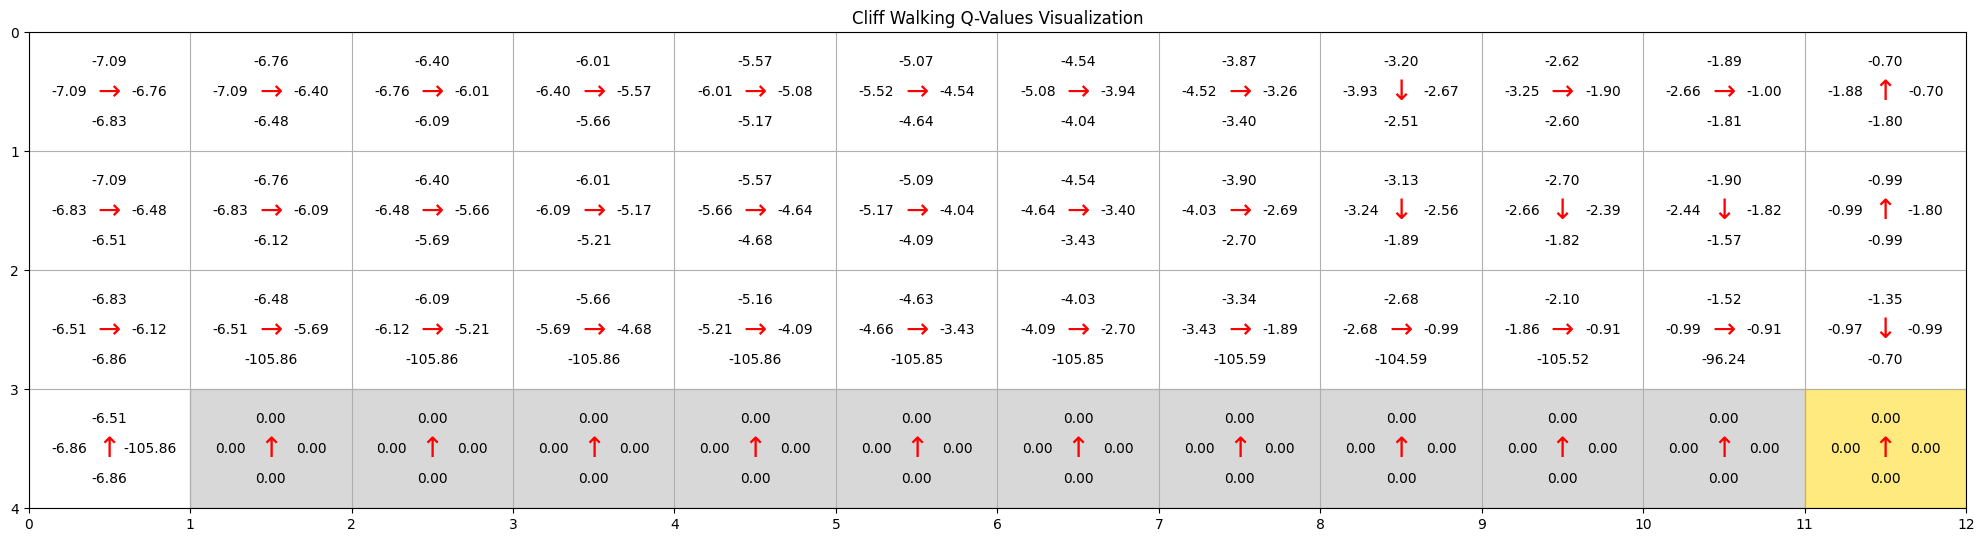

In [90]:
Q_table_final, _ = learning()
rows, cols = 4, 12
actions = ['↑', '→', '↓', '←']

fig, ax = plt.subplots(figsize=(25, 7))


for row in range(rows):
    for col in range(cols):
        state = row * cols + col

        for action, (dx, dy) in zip(actions, [(0, -0.25), (0.25, 0), (0, 0.25), (-0.25, 0)]):
            ax.text(col + 0.5 + dx, row + 0.5 + dy, f'{Q_table_final[state, actions.index(action)]:.2f}', 
                    ha='center', va='center', color='black')

        best_action = np.argmax(Q_table_final[state])
        ax.text(col + 0.5, row + 0.5, actions[best_action], ha='center', va='center', color='red', fontsize=20)


ax.add_patch(plt.Rectangle((1, 3), 10, 1, fill=True, color='gray', alpha=0.3))
ax.add_patch(plt.Rectangle((11, 3), 1, 1, fill=True, color='gold', alpha=0.5)) 

ax.set_xticks(np.arange(13))
ax.set_yticks(np.arange(5))
ax.set_xticklabels(np.arange(13))
ax.set_yticklabels(np.arange(5))
ax.grid(which='both')
plt.gca().invert_yaxis() 
plt.subplots_adjust(bottom=0.2)

plt.title('Cliff Walking Q-Values Visualization')
plt.show()
